# Ordered MNIST (torch)

We begin by getting the Ordered MNIST dataset from `kooplearn` and plotting a small sample out of it

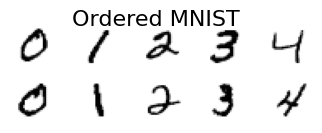

In [1]:
from kooplearn.datasets import fetch_ordered_mnist
import matplotlib.pyplot as plt
# We only use the digits 0 to 4 
num_digits = 5
images, labels = fetch_ordered_mnist(num_digits=num_digits)
# Plot the data
fig, axs = plt.subplots(nrows=2, ncols=num_digits, figsize=(0.8*num_digits, 1.3))
for img, ax in zip(images, axs.ravel()):
    ax.imshow(img, cmap="Greys")
    ax.axis("off")
fig.suptitle("Ordered MNIST", fontsize=16)
plt.show()

We split the dataset into train/validation/test (3k points for training, 1k for testing and 1k for validation)

In [2]:
import numpy as np
# train images will be images[train_ids] and so on
train_ids, val_ids, test_ids = np.split(np.arange(5000), [3000, 4000])

This example closely follows the experiment from <cite data-footcite="Kostic2023DPNets">Kostic et al. 2024</cite>. Each koopman operator model trained will be validated as follows: starting from a test image of the digit $c$, we will predict the next image by calling `model.predict`. The prediction should be an MNIST-alike image of the digit $c+1$ (modulo `configs.classes`). We will feed this prediction to a very strong MNIST classifier, and evaluate how its accuracy degrades over time. We begin by defining the _oracle_ classifier

In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

class CNNEncoder(torch.nn.Module):
    def __init__(self, num_classes):
        super(CNNEncoder, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 5, 1, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )
        # Fully connected layer, output num_classes classes
        self.out = torch.nn.Linear(32 * 7 * 7, num_classes)

    def forward(self, X):
        if X.dim() == 3:
            X = X.unsqueeze(1)  # Add a channel dimension if needed
        X = self.conv1(X)
        X = self.conv2(X)
        # Flatten the output of conv2
        X = X.view(X.size(0), -1)
        output = self.out(X)
        return output

# Will be needed for autoencoder-based koopman operator learning.     
class CNNDecoder(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(CNNDecoder, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(num_classes, 32 * 7 * 7)
        )
        
        self.conv1 = torch.nn.Sequential(  
            torch.nn.Upsample(scale_factor=2),
            torch.nn.ReLU(),   
            torch.nn.ConvTranspose2d(
                in_channels=32,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            )                            
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2),
            torch.nn.ReLU(),                               
            torch.nn.ConvTranspose2d(16, 1, 5, 1, 2)                
        )
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 32, 7, 7)
        x = self.conv1(x)
        x = self.conv2(x)
        #Remove the channel dimension
        x = x.squeeze(1)
        return x
    

In [4]:
def train_oracle_classifier():
    torch.manual_seed(42)
    num_epochs = 20
    # Prepare data
    # (1) Convert to PyTorch tensors
    X_train = torch.tensor(images[train_ids], dtype=torch.float32)
    labels_train = torch.tensor(labels[train_ids], dtype=torch.long)
    X_val = torch.tensor(images[val_ids], dtype=torch.float32)
    labels_val = torch.tensor(labels[val_ids], dtype=torch.long)
    # (2) Create data loaders
    train_dataset = TensorDataset(X_train, labels_train)
    train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_dataset = TensorDataset(X_val, labels_val)
    val_dl = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    # Define model and optimizer
    oracle = CNNEncoder(num_classes=num_digits).to(device)
    optimizer = torch.optim.AdamW(oracle.parameters(), lr=8e-4)
    
    def step(images, labels, is_train: bool = True):
        if is_train:
            oracle.train()
        else:
            oracle.eval()
        
        images, labels = images.to(device), labels.to(device)
        
        if is_train:
            optimizer.zero_grad()

        outputs = oracle(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        if is_train:
            loss.backward()
            optimizer.step()

        acc = (outputs.argmax(1) == labels).float().mean().item()
        return acc
    
    for epoch in range(num_epochs):
        train_acc = []
        val_acc = []
        for batch in train_dl:
            train_acc.append(step(*batch))
        with torch.no_grad():
            for batch in val_dl:
                val_acc.append(step(*batch, is_train=False))
        if (epoch + 1)%5 == 0 or (epoch == 0):
            print(f"EPOCH {epoch + 1:>2}  Accuracy: {np.mean(train_acc)*100:.1f}% (train) -  {np.mean(val_acc)*100:.1f}% (val)")
    return oracle
oracle = train_oracle_classifier()

EPOCH  1  Accuracy: 78.5% (train) -  94.8% (val)
EPOCH  5  Accuracy: 97.9% (train) -  97.5% (val)
EPOCH 10  Accuracy: 99.5% (train) -  98.3% (val)
EPOCH 15  Accuracy: 99.8% (train) -  99.0% (val)
EPOCH 20  Accuracy: 100.0% (train) -  98.9% (val)


### Evolution Operator Models

In [ ]:
# Global variable collecting the trained models
trained_models = {}

#### Linear Ridge Regression

In [8]:
from kooplearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from kooplearn.preprocessing import FeatureFlattener

# Data preparation
flattener = FeatureFlattener()
scaler = StandardScaler()
data_pipe = Pipeline([("flattener", flattener), ("scaler", scaler)])
data_pipe.fit(images[train_ids])

linear_model = Ridge(n_components=num_digits, eigen_solver="dense")
linear_model.fit(data_pipe.transform(images[train_ids]))
trained_models["Linear"] = {"model": linear_model, "embedder": data_pipe}

### Classifier features (as in Sec. 6 of Kostic et al. 2022)

In [9]:
from kooplearn.torch.utils import FeatureMapEmbedder

embedder = FeatureMapEmbedder(encoder=oracle)
images_embedded = embedder.transform(images[train_ids])
classifier_model = Ridge(n_components=num_digits).fit(
    images_embedded, y=images[train_ids]
)
trained_models["Classifier_Baseline"] = {
    "model": classifier_model,
    "embedder": embedder,
}

### Encoder-only methods

In [22]:

class FeatureMap(torch.nn.Module):
    def __init__(self, num_digits: int, normalize_latents: bool = True):
        super().__init__()
        self.normalize_latents = normalize_latents
        self.backbone = CNNEncoder(num_classes=num_digits)
        self.lin = torch.nn.Linear(num_digits, num_digits, bias=False)
    
    def forward(self, X, lagged:bool=False):
        z = self.backbone(X)
        if self.normalize_latents:
            z = torch.nn.functional.normalize(z, dim=-1)
        if lagged:
            z = self.lin(z)
        return z
    
def train_encoder_only(criterion: torch.nn.Module):
    num_epochs = 30
    train_dataset = torch.from_numpy(images[train_ids]).float()
    val_dataset = torch.from_numpy(images[val_ids]).float()
    # Poor's man lagged dataloaders
    batch_size = 64
    train_dl = DataLoader(TensorDataset(train_dataset[:-1], train_dataset[1:]), batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(TensorDataset(val_dataset[:-1], val_dataset[1:]), batch_size=batch_size)

    torch.manual_seed(42)
    # Initialize model, loss and optimizer
    model = FeatureMap(num_digits).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

    def step(batch, is_train:bool = True):
        batch_X, batch_Y = batch
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device) 
        if is_train:
            optimizer.zero_grad()
        phi_X, phi_Y = model(batch_X), model(batch_Y, lagged=True)
        loss = criterion(phi_X, phi_Y)
        if is_train:
            loss.backward()
            optimizer.step()
        return loss.item()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = []
        for batch in train_dl:
            train_loss.append(step(batch))
        # Validation phase
        model.eval()
        val_loss = []
        with torch.no_grad():
            for batch in val_dl:
                val_loss.append(step(batch, is_train=False))

        if (epoch + 1)%5 == 0 or (epoch == 0):
            print(f"EPOCH {epoch + 1:>2}  Loss: {np.mean(train_loss):.2f} (train) -  {np.mean(val_loss):.2f} (val)")
    
    embedder = FeatureMapEmbedder(encoder=model)
    evolution_operator_model = Ridge(n_components=num_digits).fit(embedder.transform(train_dataset), train_dataset.numpy(force=True))

    return {
        "model": evolution_operator_model,
        "embedder": embedder,
    }


In [23]:
from kooplearn.torch.nn import VampLoss, SpectralContrastiveLoss

for name, criterion in zip(["VAMPNets", "Spectral Contrastive Loss"], [ VampLoss(center_covariances=False), SpectralContrastiveLoss()]):
    print(f"Fitting {name}")
    trained_models[name] = train_encoder_only(criterion)

Fitting VAMPNets
EPOCH  1  Loss: -3.80 (train) -  -4.38 (val)
EPOCH  5  Loss: -4.80 (train) -  -4.58 (val)
EPOCH 10  Loss: -4.93 (train) -  -4.67 (val)
EPOCH 15  Loss: -4.96 (train) -  -4.66 (val)
EPOCH 20  Loss: -4.97 (train) -  -4.69 (val)
EPOCH 25  Loss: -4.98 (train) -  -4.69 (val)
EPOCH 30  Loss: -4.98 (train) -  -4.69 (val)
Fitting Spectral Contrastive Loss
EPOCH  1  Loss: -0.94 (train) -  -1.00 (val)
EPOCH  5  Loss: -1.00 (train) -  -1.00 (val)
EPOCH 10  Loss: -1.66 (train) -  -1.88 (val)
EPOCH 15  Loss: -2.81 (train) -  -2.77 (val)
EPOCH 20  Loss: -2.95 (train) -  -2.90 (val)
EPOCH 25  Loss: -3.88 (train) -  -3.95 (val)
EPOCH 30  Loss: -4.61 (train) -  -4.59 (val)


### Dynamical Autoencoder (Lusch et al 2018)

In [ ]:
from kooplearn.torch.nn import AutoEncoderLoss
    
class DynamicalAutoEncoder(torch.nn.Module):
    def __init__(self, num_digits):
        super().__init__()
        self.encoder = CNNEncoder(num_digits).to(device)
        self.decoder = CNNDecoder(num_digits).to(device)
        self.evolution_operator = torch.nn.Linear(num_digits, num_digits, bias=False).to(device)
        self.loss = AutoEncoderLoss()
    
    def forward(self):
        pass
    
    def train_step(self, batch, optimizer, is_eval: bool = False):
        X, Y = batch
        X, Y = X.to(device), Y.to(device)
        if not is_eval:
            optimizer.zero_grad()
        X_enc, Y_enc = self.encoder(X), self.encoder(Y)
        X_rec = self.decoder(X_enc)
        X_evo = self.evolution_operator(X_enc)
        Y_pred = self.decoder(X_evo)
        loss = self.loss(X, Y, X_rec, Y_enc, X_evo, Y_pred)
        if not is_eval:
            loss.backward()
            optimizer.step()
        return loss.item()

def train_autoencoder():
    torch.manual_seed(42)
    num_epochs = 100
    train_dataset = torch.from_numpy(images[train_ids]).float()
    val_dataset = torch.from_numpy(images[val_ids]).float()
    # Poor's man lagged dataloaders
    batch_size = 64
    train_dl = DataLoader(TensorDataset(train_dataset[:-1], train_dataset[1:]), batch_size=batch_size, shuffle=True)
    val_dl = DataLoader(TensorDataset(val_dataset[:-1], val_dataset[1:]), batch_size=batch_size)
    # Model and optimizer
    model = DynamicalAutoEncoder(num_digits)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        model.train()
        train_loss = []
        for batch in train_dl:
            train_loss.append(model.train_step(batch, optimizer))
        # Validation phase
        model.eval()
        val_loss = []
        with torch.no_grad():
            for batch in val_dl:
                val_loss.append(model.train_step(batch, optimizer, is_eval=True))

        if (epoch + 1)%5 == 0 or (epoch == 0):
            print(f"EPOCH {epoch + 1:>2}  Loss: {np.mean(train_loss):.2f} (train) -  {np.mean(val_loss):.2f} (val)")
    
    embedder = FeatureMapEmbedder(encoder=model.encoder, decoder=model.decoder)
    evolution_operator_model = Ridge(n_components=num_digits).fit(embedder.transform(train_dataset))

    return {
        "model": evolution_operator_model,
        "embedder": embedder,
    }

trained_models["AutoEncoder"] = train_autoencoder()

EPOCH  1  Loss: 0.17 (train) -  0.14 (val)
EPOCH  5  Loss: 0.13 (train) -  0.12 (val)
EPOCH 10  Loss: 0.10 (train) -  0.10 (val)
EPOCH 15  Loss: 0.10 (train) -  0.10 (val)
EPOCH 20  Loss: 0.10 (train) -  0.10 (val)
EPOCH 25  Loss: 0.09 (train) -  0.10 (val)
EPOCH 30  Loss: 0.09 (train) -  0.10 (val)
EPOCH 35  Loss: 0.09 (train) -  0.10 (val)
EPOCH 40  Loss: 0.09 (train) -  0.10 (val)
EPOCH 45  Loss: 0.09 (train) -  0.10 (val)
EPOCH 50  Loss: 0.09 (train) -  0.10 (val)
EPOCH 55  Loss: 0.09 (train) -  0.10 (val)
EPOCH 60  Loss: 0.09 (train) -  0.10 (val)
EPOCH 65  Loss: 0.09 (train) -  0.10 (val)
EPOCH 70  Loss: 0.08 (train) -  0.10 (val)
EPOCH 75  Loss: 0.08 (train) -  0.10 (val)
EPOCH 80  Loss: 0.08 (train) -  0.10 (val)
EPOCH 85  Loss: 0.08 (train) -  0.10 (val)
EPOCH 90  Loss: 0.08 (train) -  0.10 (val)
EPOCH 95  Loss: 0.08 (train) -  0.10 (val)


The rank attribute has been updated to 4.
Consider decreasing the rank parameter.


EPOCH 100  Loss: 0.08 (train) -  0.11 (val)


## Final comparison
### Model evaluation function

In [50]:
test_data = images[test_ids]
test_labels = labels[test_ids]
def evaluate_model(model, embedder, num_evaluation_steps = 15):
    report = {
        'accuracy': [],
        'label': [],
        'image': [],
        'times': []
    }
    img = test_data
    for t in range(1, num_evaluation_steps + 1):
        if hasattr(embedder, "decoder") and embedder.decoder is None:
            img = model.predict(embedder.transform(img), observable=True)
        else:
            _img = model.predict(embedder.transform(img))
            img = embedder.inverse_transform(_img)
        pred_labels = oracle(torch.tensor(img, device=device, dtype=torch.float)).argmax(axis=1).numpy(force=True)
        accuracy = (pred_labels == (test_labels + t)%num_digits).mean()
        report['accuracy'].append(accuracy.item())
        report['image'].append(img)
        report['label'].append(pred_labels)
        report['times'].append(t)
    return report

report = {}

for model_name, result in trained_models.items():
    report[model_name] = evaluate_model(result["model"], result["embedder"])

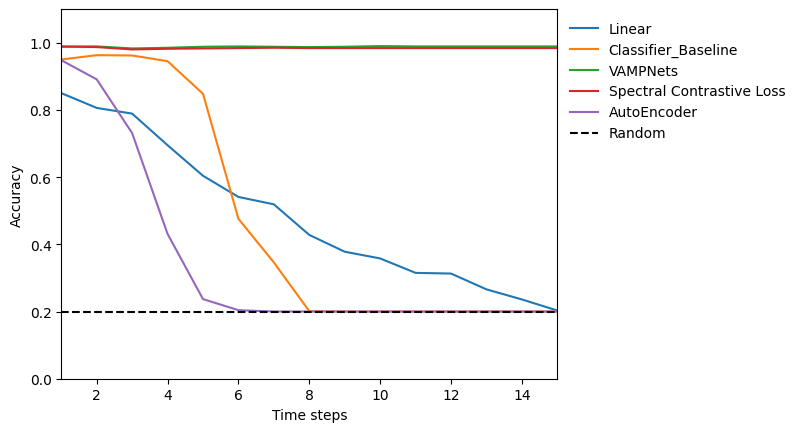

In [48]:
fig, ax = plt.subplots()
for model_name in report.keys():
    t = report[model_name]['times']
    acc = report[model_name]['accuracy']
    ax.plot(t, acc, label=model_name)

ax.axhline(1/num_digits, color='black', linestyle='--', label='Random')

ax.legend(frameon=False, bbox_to_anchor=(1, 1))
ax.margins(x=0)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Time steps')
ax.set_ylabel('Accuracy')
plt.show()

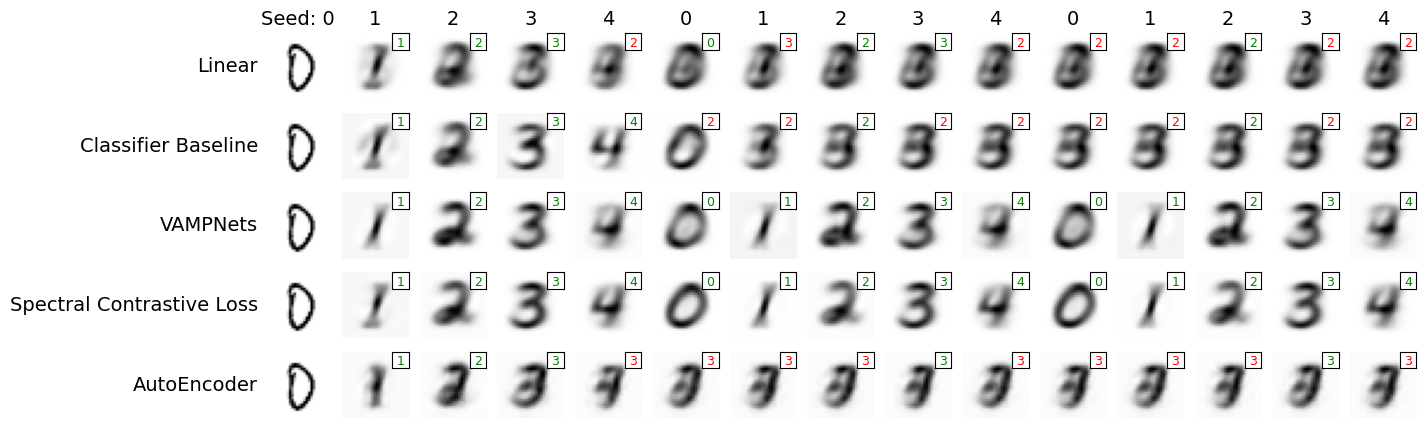

In [54]:
nun_models = len(report)
num_cols = len(report['Linear']['times'])
fig, axes = plt.subplots(nun_models, num_cols, figsize=(num_cols, nun_models), sharex=True, sharey=True)

test_seed_idx = 0
# Remove margins between columns
plt.subplots_adjust(wspace=0)

for model_idx, model_name in enumerate(report.keys()):
    # First column
    ax = axes[model_idx, 0]
    ax.imshow(test_data[test_seed_idx], cmap='Greys')
    ax.set_axis_off()

    for prediction_step in range(num_cols - 1):
        pred_label = report[model_name]['label'][prediction_step][test_seed_idx]
        true_label = (test_labels[test_seed_idx] + report[model_name]['times'][prediction_step])%num_digits
        img = report[model_name]['image'][prediction_step][test_seed_idx]

        # Set subplot for the current class
        ax = axes[model_idx, prediction_step + 1]

        # Plot the MNIST image
        ax.imshow(img, cmap='Greys')

        # Remove axes and ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

        # Add a white background for the subplot
        ax.set_facecolor('white')

        # Add an inset for the predicted label in the upper right corner
        if pred_label == true_label:
            color = 'green'
        else:
            color = 'red'
        inset_ax = ax.inset_axes([0.75, 0.75, 0.25, 0.25])
        inset_ax.set_xlim(0, 1)
        inset_ax.set_ylim(0, 1)
        inset_ax.text(0.5, 0.4, f"{pred_label}" , color=color, fontsize=9, ha='center', va='center')
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        inset_ax.set_facecolor('white')

# Display the model names on the left of each row
for model_idx, model_name in enumerate(report.keys()):
    axes[model_idx, 0].text(-0.1, 0.5, model_name.replace('_', ' '), fontsize=14, ha='right', va='center', transform=axes[model_idx, 0].transAxes)

for class_idx in range(num_cols):
    title = (test_labels[test_seed_idx] + class_idx)%num_digits
    if class_idx == 0:
        axes[0, class_idx].set_title(f"Seed: {title}", fontsize=14)
    else:
        axes[0, class_idx].set_title(f"{title}", fontsize=14)
plt.show()

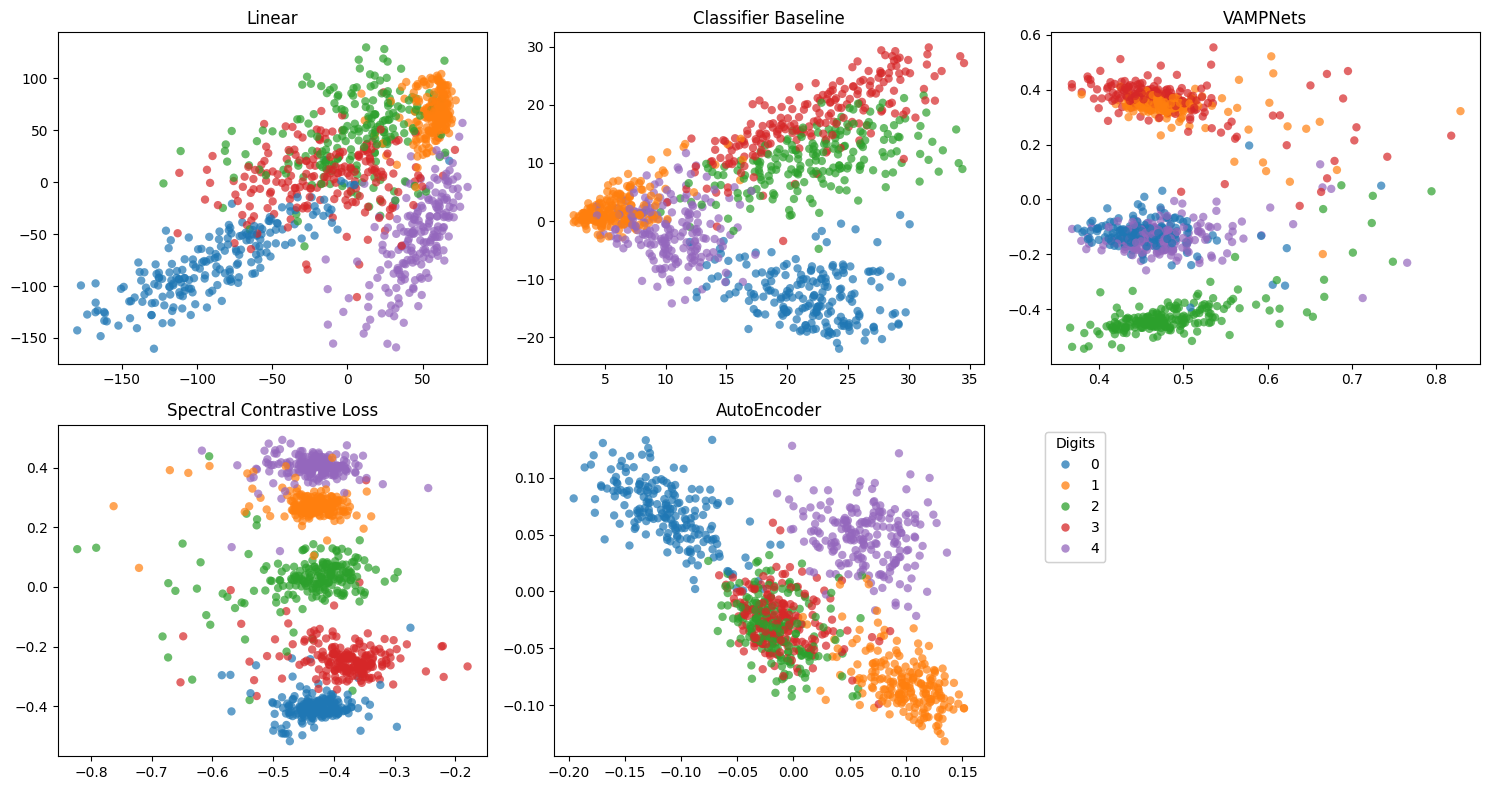

In [ ]:
from kooplearn._utils import stable_topk

n_models = len(report.keys())
num_rows, num_cols = 2, 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axes = axes.flatten()
for model_idx, model_name in enumerate(report.keys()):
    ax = axes[model_idx]
    ax.title.set_text(model_name.replace('_', ' '))
    fitted_model = trained_models[model_name]['model']
    embedder = trained_models[model_name]['embedder']
    vals, lfuncs, rfuncs = fitted_model.eig(eval_right_on=embedder.transform(test_data), eval_left_on=embedder.transform(test_data))
    
    unique_vals, idx_start = np.unique(np.abs(vals), return_index=True) # returns the unique values and the index of the first occurrence of a value
    
    vals, lfuncs, rfuncs = vals[idx_start], lfuncs[:, idx_start], rfuncs[:, idx_start]
    top_vals, top_indices = stable_topk(np.abs(vals), 2)
    idx_i = top_indices[0]
    idx_j = top_indices[1]
    
    fns = lfuncs
    fn_i = fns[:, idx_i].real
    fn_j = fns[:, idx_j].real
    
    scatter = ax.scatter(fn_i, fn_j, c=test_labels, cmap='tab10', vmax=10, alpha=0.7, linewidths=0)
    
# remove last axis and add legend
ax = axes[n_models-1]
legend = ax.legend(*scatter.legend_elements(num=4), title="Digits", frameon=True, bbox_to_anchor=(1.3, 1))
ax.add_artist(legend)
fig.delaxes(axes[n_models])
    
plt.tight_layout()
plt.show()